In [ ]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from diffusers import DDPMPipeline
from tqdm.notebook import tqdm

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## Setting DDPM Configuration

In [ ]:
from dataclasses import dataclass

@dataclass
class DDPMConfig:
    image_size = 64
    train_batch_size = 32
    eval_batch_size = 32
    num_epochs = 100
    gradient_accumulation_steps = 1
    lr = 1e-4
    lr_warmup_steps = 500
    lr_scheduler='cosine'
    save_image_epochs = 10
    save_model_epochs = 30
    device = "cuda" if torch.cuda.is_available() else "cpu"

config = DDPMConfig()

## Loading Dataset

In [ ]:
from datasets import load_dataset

dataset_name = "huggan/pokemon"
dataset = load_dataset(dataset_name, split="train")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/7357 [00:00<?, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 7357
})

## Transformation for images

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomCrop(config.image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

## Sample some images

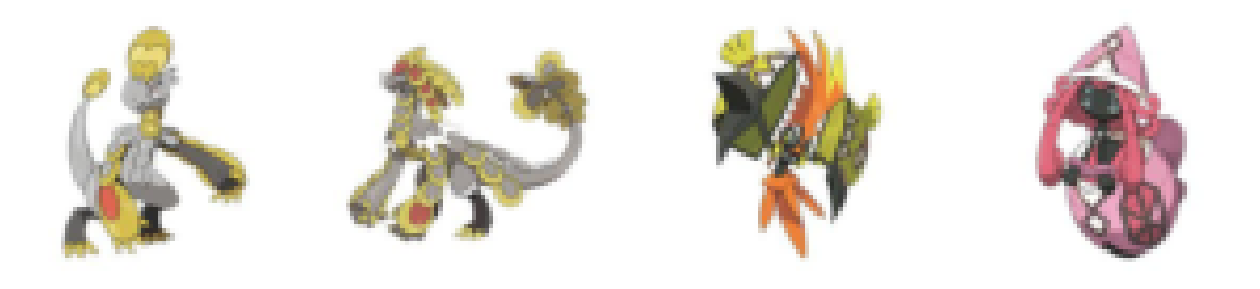

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[18:22]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 64, 64])


## Create DDPM Scheduler for Noise

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

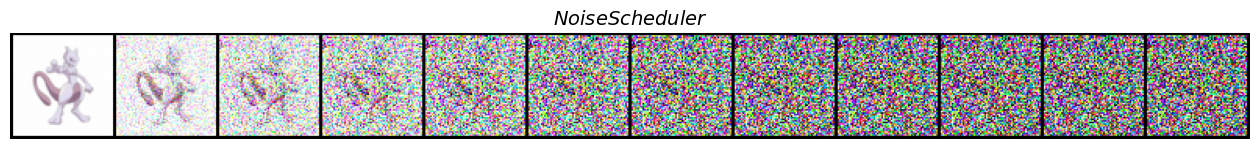

In [ ]:
import torch
from PIL import Image
import numpy as np

def show_images(x):
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, nrow=12)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    figure = plt.figure(figsize=(16, 4))
    plt.imshow(grid_im)
    plt.title(r"$Noise Scheduler$", fontsize=14)
    plt.axis("off")
    plt.show()

timesteps = torch.linspace(0, 999, 12).long()
noise = torch.randn(sample_image.shape)
noisy_images = noise_scheduler.add_noise(sample_image, noise, timesteps)

show_images(noisy_images)

## Define DDPM Model

In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

model.to(config.device)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

In [ ]:
print('Output shape:', model(sample_image.to(config.device), timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 64, 64])


## Training DDPM Model

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, betas=(0.95, 0.999), weight_decay=1e-6, eps=1e-8)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
time_steps = []
mse_losses = []
losses = []

In [ ]:
from diffusers import DDPMPipeline

  0%|          | 0/230 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

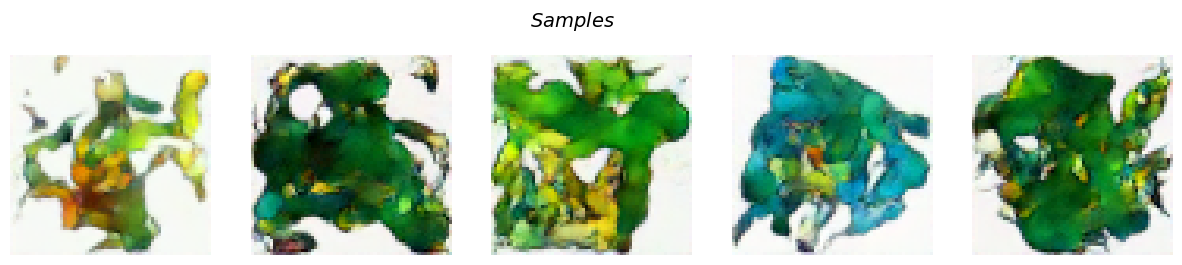

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

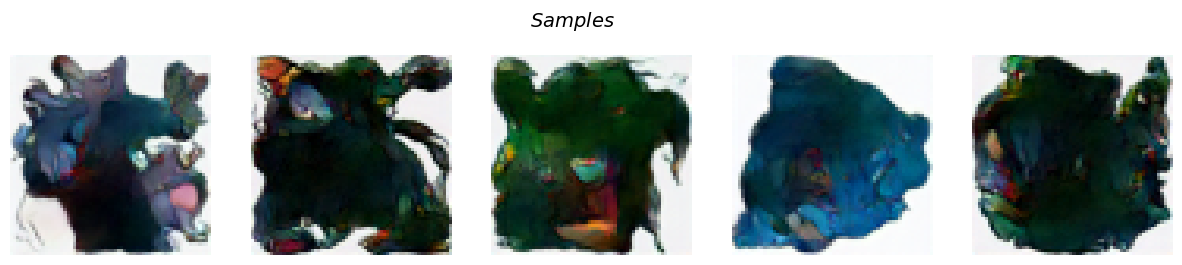

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

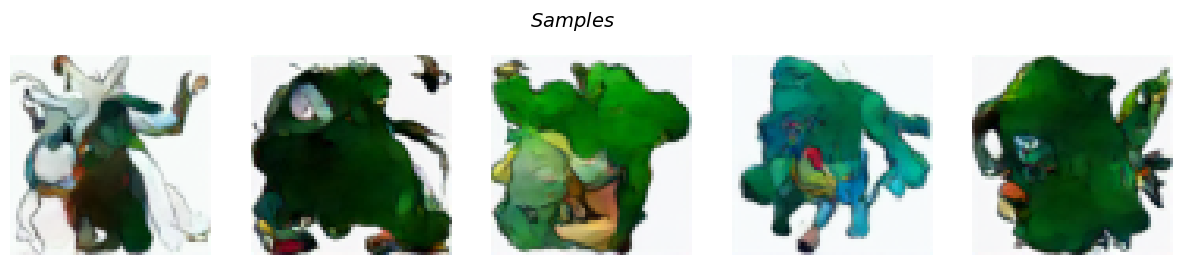

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

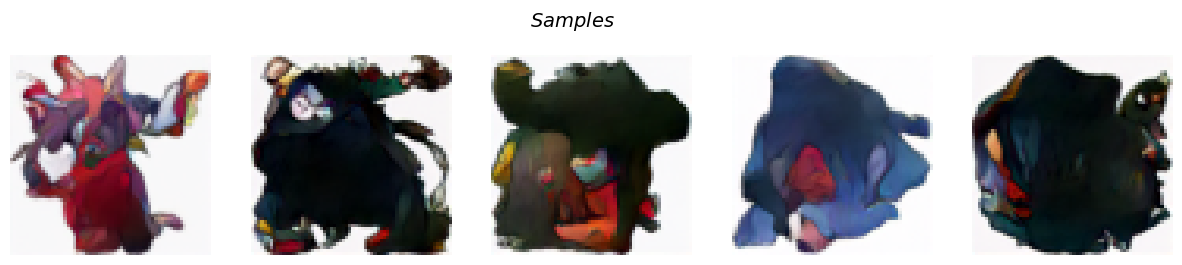

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

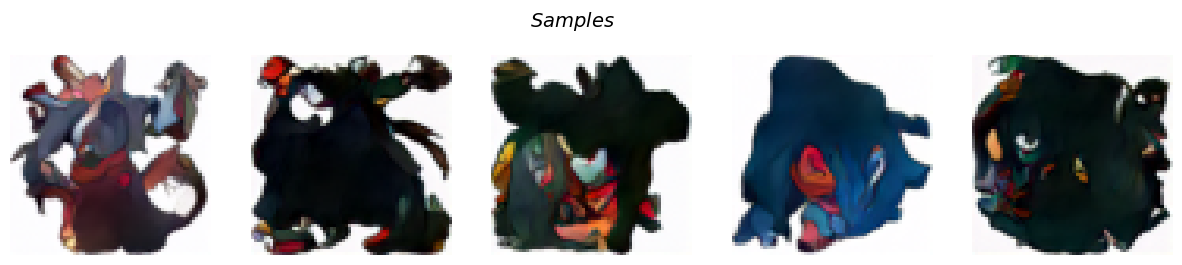

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

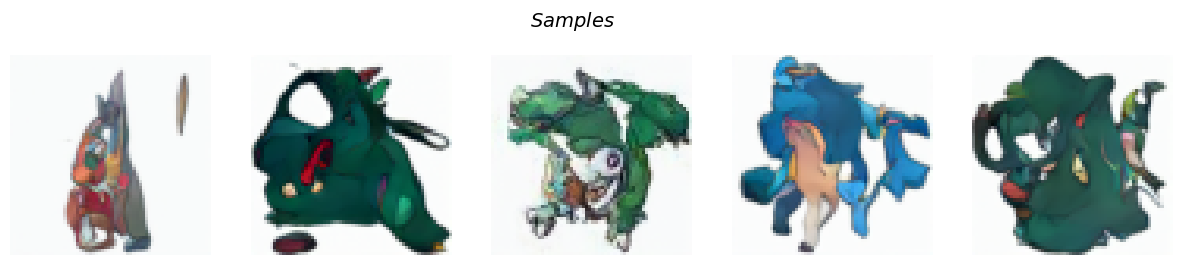

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

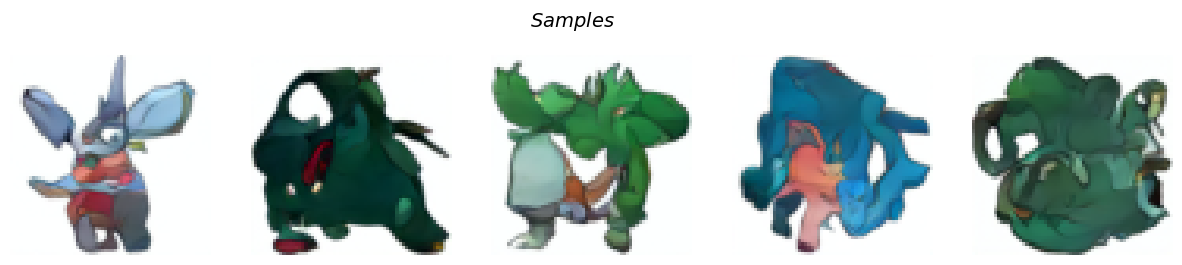

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

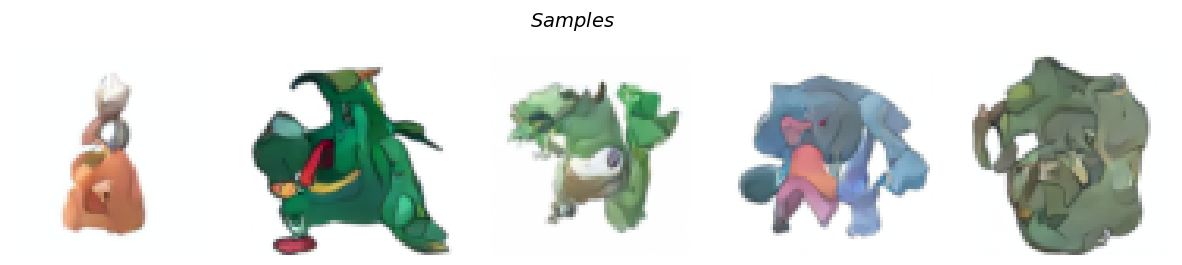

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

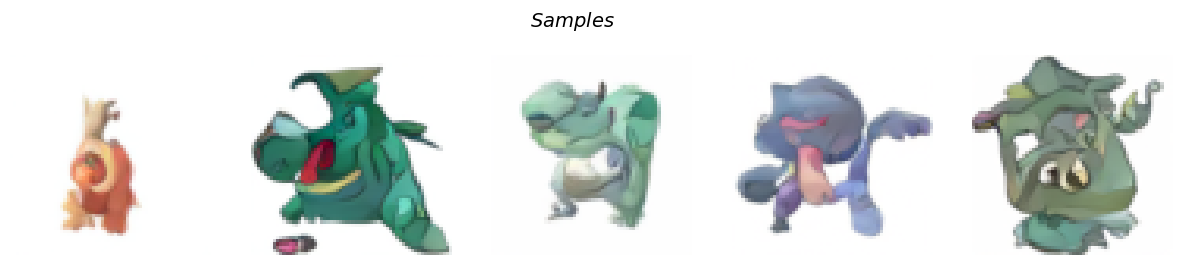

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

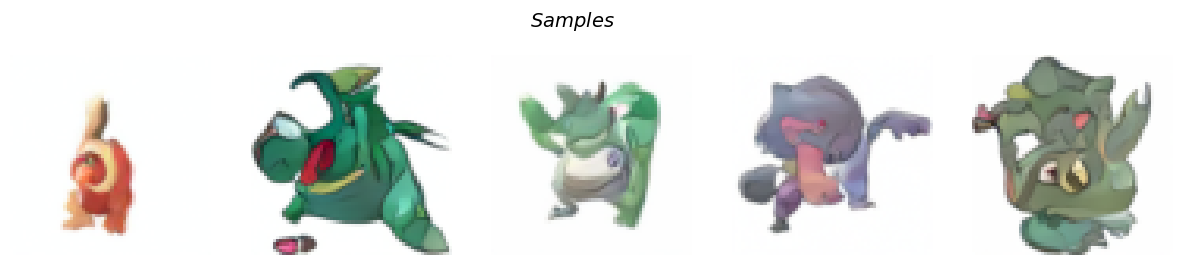

In [ ]:
from accelerate import Accelerator
from tqdm.auto import tqdm

accelerator = Accelerator(
        mixed_precision="no",
        gradient_accumulation_steps=config.gradient_accumulation_steps,
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
)


global_step = 0

for epoch in range(config.num_epochs):

    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")

    model.train()

    for step, batch in enumerate(train_dataloader):

        images = batch["images"].to(config.device)
        noise = torch.randn(images.shape).to(config.device)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (images.shape[0],)).long().to(config.device)
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

        with accelerator.accumulate(model):

             noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
             loss = criterion(noise_pred, noise)
             accelerator.backward(loss)
             mse_losses.append(loss.item())

             accelerator.clip_grad_norm_(model.parameters(), 1.0)
             optimizer.step()
             lr_scheduler.step()
             optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
        global_step += 1

    loss_epoch = sum(mse_losses[-len(train_dataloader) :]) / len(train_dataloader)
    losses.append(loss_epoch)


    if(epoch+1)%10 == 0:
       model.eval()

       with torch.no_grad():
        # sample_plot_image()
        # time_steps.append(epoch)
        pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
        images = pipeline(
              batch_size = 5,
              generator=torch.manual_seed(0),
         ).images
        figure = plt.figure(figsize=(15, 3))
        figure.add_subplot(1, 5, 1)
        plt.imshow(images[0])
        plt.axis("off")
        figure.add_subplot(1, 5, 2)
        plt.imshow(images[1])
        plt.axis("off")
        figure.add_subplot(1, 5, 3)
        plt.imshow(images[2])
        plt.axis("off")
        figure.add_subplot(1, 5, 4)
        plt.imshow(images[3])
        plt.axis("off")
        figure.add_subplot(1, 5, 5)
        plt.imshow(images[4])
        plt.axis("off")
        figure.suptitle(r'$Samples$', fontsize=14)
        plt.show()






In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.push_to_hub("ddpm-pokemon-64-v2")
noise_scheduler.push_to_hub("ddpm-pokemon-64-v2")

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/FelixChao/ddpm-pokemon-64-v2/commit/2a33772f5274e177ccd90a3ddf436e0d2459d65f', commit_message='Upload scheduler', commit_description='', oid='2a33772f5274e177ccd90a3ddf436e0d2459d65f', pr_url=None, pr_revision=None, pr_num=None)

  0%|          | 0/1000 [00:00<?, ?it/s]

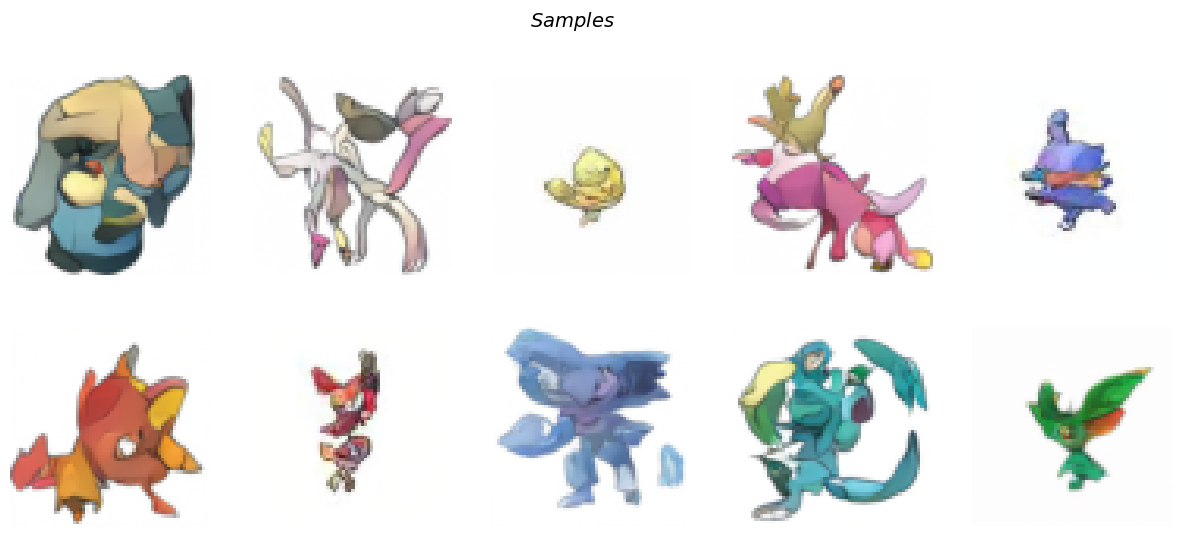

In [ ]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
images = pipeline(
              batch_size = 10,
         ).images
figure = plt.figure(figsize=(15, 6))
figure.add_subplot(2, 5, 1)
plt.imshow(images[0])
plt.axis("off")
figure.add_subplot(2, 5, 2)
plt.imshow(images[1])
plt.axis("off")
figure.add_subplot(2, 5, 3)
plt.imshow(images[2])
plt.axis("off")
figure.add_subplot(2, 5, 4)
plt.imshow(images[3])
plt.axis("off")
figure.add_subplot(2, 5, 5)
plt.imshow(images[4])
plt.axis("off")
figure.add_subplot(2, 5, 6)
plt.imshow(images[5])
plt.axis("off")
figure.add_subplot(2, 5, 7)
plt.imshow(images[6])
plt.axis("off")
figure.add_subplot(2, 5, 8)
plt.imshow(images[7])
plt.axis("off")
figure.add_subplot(2, 5, 9)
plt.imshow(images[8])
plt.axis("off")
figure.add_subplot(2, 5, 10)
plt.imshow(images[9])
plt.axis("off")
figure.suptitle(r'$Samples$', fontsize=14)
plt.show()